In [1]:
import os
from datetime import datetime
from typing import Optional

from netCDF4 import Dataset
import spacepy.pycdf
import h5py
import numpy as np
import pandas as pd
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import re

import pyDMSP

In [2]:
ssies3_fp = r"G:\0_postgraduate\DMSP\data\2014\f16\ssies3\dmsp-f16_ssies-3_thermal-plasma_201401010137_v01.cdf"
ssies3 = pyDMSP.CDFFile(ssies3_fp, is_f17=False)
ssies3_data = ssies3.ssies3_data()

In [3]:
ssm_fp = r"G:\0_postgraduate\DMSP\data\2014\f16\ssm\dmsp-f16_ssm_magnetometer_20140101_v1.0.4.cdf"
ssm = pyDMSP.CDFFile(ssm_fp, is_f17=False)
ssm_data = ssm.ssm_data()

In [4]:
# ssm clip
st = ssies3_data['timestamps'].iloc[0]
et = ssies3_data['timestamps'].iloc[-1]
s_idx = np.where(ssm_data['timestamps'] == st)
e_idx = np.where(ssm_data['timestamps'] == et)
ssm_data_clip = ssm_data.iloc[s_idx[0][0]:e_idx[0][0] + 1].reset_index(drop=True)

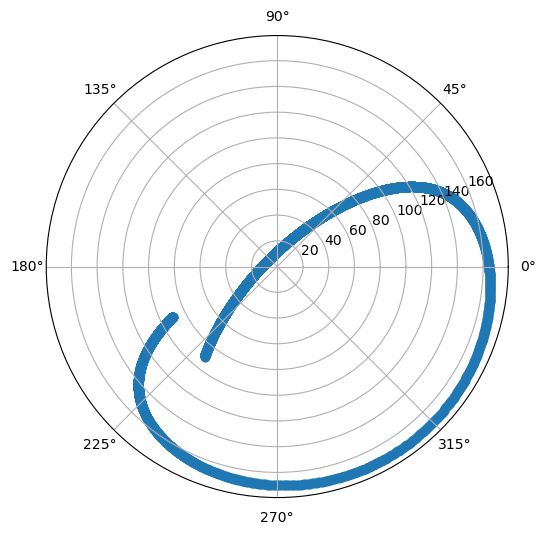

In [5]:
glat = ssies3_data['glat']
glon = ssies3_data['glon']

longitude_rad = np.radians(glon)
latitude_from_pole_north = 90 - glat

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(polar=True)
ax.scatter(longitude_rad,latitude_from_pole_north)

In [6]:
vx_set_nan = ssies3.vx_set_nan()
filter = vx_set_nan['timestamps'].isin(ssies3_data['timestamps'])
vx_set_nan_filter = vx_set_nan[filter].reset_index(drop=True)

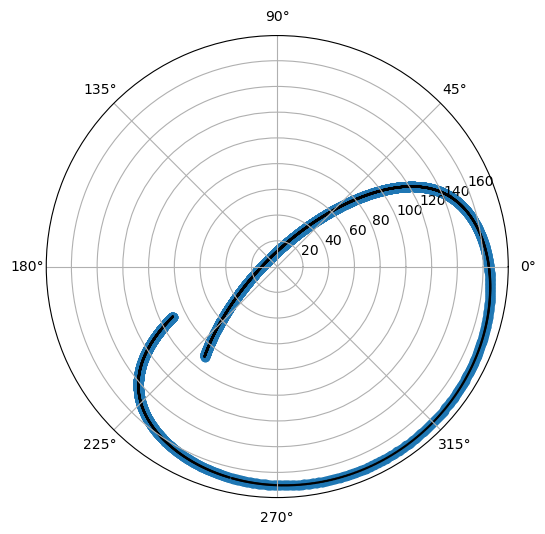

In [42]:
glat = ssies3_data['glat']
glon = ssies3_data['glon']

longitude_rad = np.radians(glon)
latitude_from_pole_north = 90 - glat
# 计算差分以得到切线方向
delta_lon = np.diff(longitude_rad, prepend=longitude_rad[0])  # 在开头补充第一个元素以保持数组长度一致
delta_lat = np.diff(latitude_from_pole_north, prepend=latitude_from_pole_north[0])
# 计算垂直于切线的方向（正交旋转）
perpendicular_lon = -delta_lat
perpendicular_lat = delta_lon

# # 计算差分以得到切线方向
# delta_lon = np.diff(longitude_rad, prepend=longitude_rad[0])  # 在开头补充第一个元素以保持数组长度一致
# delta_lat = np.diff(latitude_from_pole_north, prepend=latitude_from_pole_north[0])
# 
# # 计算垂直于切线的方向（正交旋转）
# perpendicular_lon = -delta_lat
# perpendicular_lat = delta_lon

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111,polar=True)

speeds = vx_set_nan_filter['vx']
# 归一化速度并缩放
normalized_speeds = 0.05 * np.abs(speeds) / np.max(np.abs(speeds))  # 归一化速度

ax.scatter(longitude_rad,latitude_from_pole_north)
ax.quiver(longitude_rad, latitude_from_pole_north, np.arctan(perpendicular_lon),np.arctan(perpendicular_lat),
          units='xy', scale=10.,
          width=0.7, headwidth=3., headlength=4.)

# # 绘制向量，考虑速度正负
# for lon, lat, u, v, speed in zip(longitude_rad, latitude_from_pole_north, perpendicular_lon, perpendicular_lat, normalized_speeds):
#     angle = np.arctan2(v, u)  # 计算切线的角度
#     angle_perpendicular = angle + np.pi/2 * np.sign(speed)  # 根据速度正负调整垂直角度
#     ax.quiver(lon, lat, np.cos(angle_perpendicular), np.sin(angle_perpendicular),
#               angles='xy', scale_units='xy', scale=1, pivot='mid')


# for lon, lat, speed in zip(longitude_rad, latitude_from_pole_north, vx_set_nan_filter['vx']):
#     direction = np.pi/2 if speed >= 0 else -np.pi/2  # 选择向上或向下的方向
#     ax.quiver(lon, lat, 0, np.cos(direction) * abs(speed),  # x分量为0, y分量根据方向和速度的绝对值
#               angles='xy', scale_units='xy', scale=1, pivot='mid', color='blue')

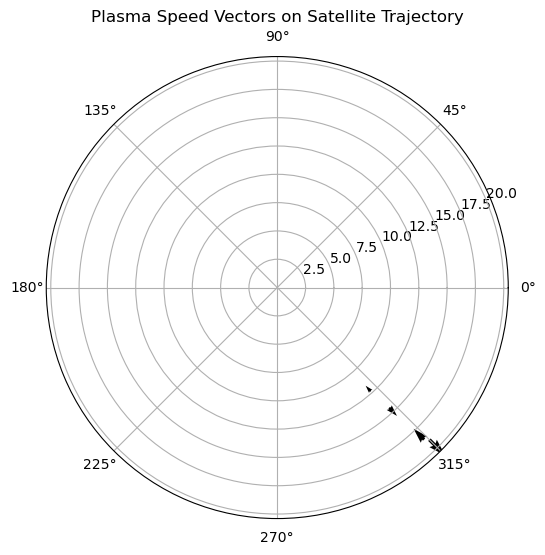

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# 假设的数据
ssm_data_clip = {
    'SC_GEOCENTRIC_LAT': np.array([70, 72, 75, 78]),  # 示例纬度数据
    'SC_GEOCENTRIC_LON': np.array([-45, -46, -47, -48]),  # 示例经度数据
    'Plasma_Speed': np.array([300, -200, 150, -100])  # 示例等离子体速度数据
}

# 转换为弧度和从极点的距离
longitude_rad = np.radians(ssm_data_clip['SC_GEOCENTRIC_LON'])
latitude_from_pole_north = 90 - ssm_data_clip['SC_GEOCENTRIC_LAT']

# 创建图和极坐标子图
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, polar=True)

# 规范化速度以控制向量长度，确保不超过图表限制
speeds = ssm_data_clip['Plasma_Speed']
max_speed = np.max(np.abs(speeds))
normalized_speeds = 2 * np.abs(speeds) / max_speed  # 取绝对值并归一化速度

# 绘制向量，方向表示速度正负
for lon, lat, speed, normalized_speed in zip(longitude_rad, latitude_from_pole_north, speeds, normalized_speeds):
    direction = 0 if speed >= 0 else np.pi  # 正速度向“上”（北），负速度向“下”（南）
    ax.quiver(lon, lat, 0, normalized_speed * np.cos(direction),  # x分量为0, y分量根据方向和速度的绝对值
              angles='xy', scale_units='xy', scale=1, pivot='mid')

# 设置标题和显示图形
plt.title('Plasma Speed Vectors on Satellite Trajectory')
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 假设的数据
ssm_data_clip = {
    'SC_GEOCENTRIC_LAT': np.array([70, 72, 75, 78]),  # 示例纬度数据
    'SC_GEOCENTRIC_LON': np.array([-45, -46, -47, -48]),  # 示例经度数据
    'Plasma_Speed': np.array([300, -200, 150, -100])  # 示例等离子体速度数据
}

# 转换为弧度和从极点的距离
longitude_rad = np.radians(ssm_data_clip['SC_GEOCENTRIC_LON'])
latitude_from_pole_north = 90 - ssm_data_clip['SC_GEOCENTRIC_LAT']

# 计算差分以得到切线方向
delta_lon = np.diff(longitude_rad, prepend=longitude_rad[0])  # 在开头补充第一个元素以保持数组长度一致
delta_lat = np.diff(latitude_from_pole_north, prepend=latitude_from_pole_north[0])

# 计算垂直于切线的方向（正交旋转）
perpendicular_lon = -delta_lat
perpendicular_lat = delta_lon

# 创建图和极坐标子图
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, polar=True)

# 规范化速度以控制向量长度
speeds = ssm_data_clip['Plasma_Speed']
normalized_speeds = 2 * speeds / np.max(np.abs(speeds))  # 归一化速度并缩放

# 绘制向量，考虑速度正负
for lon, lat, u, v, speed in zip(longitude_rad, latitude_from_pole_north, perpendicular_lon, perpendicular_lat, normalized_speeds):
    ax.quiver(lon, lat, u, v * np.sign(speed), angles='xy', scale_units='xy', scale=1, pivot='mid', color='blue' if speed >= 0 else 'red')

# 设置标题和显示图形
plt.title('Plasma Speed Vectors on Satellite Trajectory')
plt.show()


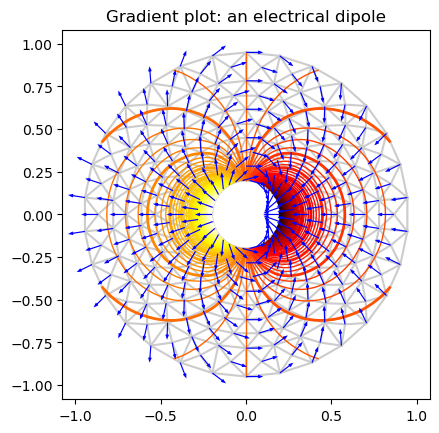

In [27]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.tri import (CubicTriInterpolator, Triangulation,
                            UniformTriRefiner)


# ----------------------------------------------------------------------------
# Electrical potential of a dipole
# ----------------------------------------------------------------------------
def dipole_potential(x, y):
    """The electric dipole potential V, at position *x*, *y*."""
    r_sq = x**2 + y**2
    theta = np.arctan2(y, x)
    z = np.cos(theta)/r_sq
    return (np.max(z) - z) / (np.max(z) - np.min(z))


# ----------------------------------------------------------------------------
# Creating a Triangulation
# ----------------------------------------------------------------------------
# First create the x and y coordinates of the points.
n_angles = 30
n_radii = 10
min_radius = 0.2
radii = np.linspace(min_radius, 0.95, n_radii)

angles = np.linspace(0, 2 * np.pi, n_angles, endpoint=False)
angles = np.repeat(angles[..., np.newaxis], n_radii, axis=1)
angles[:, 1::2] += np.pi / n_angles

x = (radii*np.cos(angles)).flatten()
y = (radii*np.sin(angles)).flatten()
V = dipole_potential(x, y)

# Create the Triangulation; no triangles specified so Delaunay triangulation
# created.
triang = Triangulation(x, y)

# Mask off unwanted triangles.
triang.set_mask(np.hypot(x[triang.triangles].mean(axis=1),
                         y[triang.triangles].mean(axis=1))
                < min_radius)

# ----------------------------------------------------------------------------
# Refine data - interpolates the electrical potential V
# ----------------------------------------------------------------------------
refiner = UniformTriRefiner(triang)
tri_refi, z_test_refi = refiner.refine_field(V, subdiv=3)

# ----------------------------------------------------------------------------
# Computes the electrical field (Ex, Ey) as gradient of electrical potential
# ----------------------------------------------------------------------------
tci = CubicTriInterpolator(triang, -V)
# Gradient requested here at the mesh nodes but could be anywhere else:
(Ex, Ey) = tci.gradient(triang.x, triang.y)
E_norm = np.sqrt(Ex**2 + Ey**2)

# ----------------------------------------------------------------------------
# Plot the triangulation, the potential iso-contours and the vector field
# ----------------------------------------------------------------------------
fig, ax = plt.subplots()
ax.set_aspect('equal')
# Enforce the margins, and enlarge them to give room for the vectors.
ax.use_sticky_edges = False
ax.margins(0.07)

ax.triplot(triang, color='0.8')

levels = np.arange(0., 1., 0.01)
ax.tricontour(tri_refi, z_test_refi, levels=levels, cmap='hot',
              linewidths=[2.0, 1.0, 1.0, 1.0])
# Plots direction of the electrical vector field
ax.quiver(triang.x, triang.y, Ex/E_norm, Ey/E_norm,
          units='xy', scale=10., zorder=3, color='blue',
          width=0.007, headwidth=3., headlength=4.)

ax.set_title('Gradient plot: an electrical dipole')
plt.show()

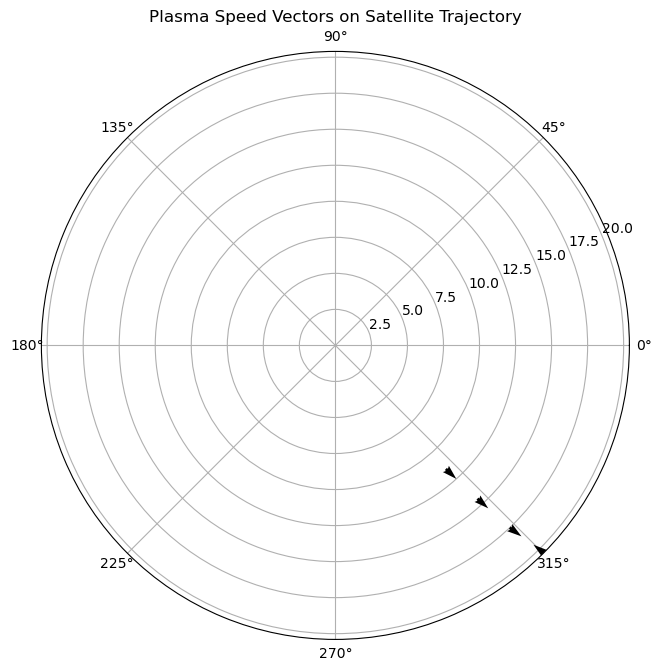

In [49]:
import numpy as np
import matplotlib.pyplot as plt

# 假设的数据
ssm_data_clip = {
    'SC_GEOCENTRIC_LAT': np.array([70, 72, 75, 78]),  # 示例纬度数据
    'SC_GEOCENTRIC_LON': np.array([-45, -46, -47, -48]),  # 示例经度数据
    'Plasma_Speed': np.array([300, -200, 150, -100])  # 示例等离子体速度数据
}

# 转换为弧度和从极点的距离
longitude_rad = np.radians(ssm_data_clip['SC_GEOCENTRIC_LON'])
latitude_from_pole_north = 90 - ssm_data_clip['SC_GEOCENTRIC_LAT']

# 计算差分以得到切线方向
delta_lon = np.diff(longitude_rad, prepend=longitude_rad[-1])  # 为闭合轨迹处理边界
delta_lat = np.diff(latitude_from_pole_north, prepend=latitude_from_pole_north[-1])

# 计算垂直于切线的方向（正交旋转）
perpendicular_lon = -delta_lat
perpendicular_lat = delta_lon

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, polar=True)

speeds = ssm_data_clip['Plasma_Speed']
max_speed = np.max(np.abs(speeds))
normalized_speeds = 2 * np.abs(speeds) / max_speed  # 归一化速度并缩放

# 绘制向量，方向基于速度正负决定垂直方向
for lon, lat, u, v, speed in zip(longitude_rad, latitude_from_pole_north, perpendicular_lon, perpendicular_lat, normalized_speeds):
    angle = np.arctan2(v, u)  # 计算切线的角度
    angle_perpendicular = angle + np.pi/2 * np.sign(speed)  # 根据速度正负调整垂直角度
    ax.quiver(lon, lat, np.cos(angle_perpendicular), np.sin(angle_perpendicular),
              angles='xy', scale_units='xy', scale=1, pivot='mid')

plt.title('Plasma Speed Vectors on Satellite Trajectory')
plt.show()


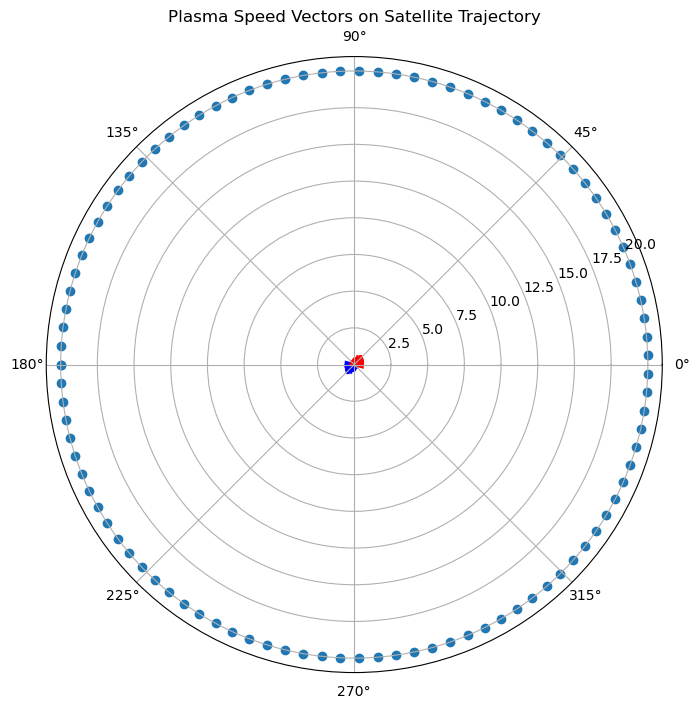

In [45]:
import numpy as np
import matplotlib.pyplot as plt

# 生成更多的数据点
num_points = 100
lon = np.linspace(-180, 180, num_points)
lat = np.linspace(70, 70, num_points)  # 维持相同的纬度以简化示例
speeds = np.sin(np.linspace(0, 2 * np.pi, num_points)) * 300  # 创建正负变化的速度

# 转换为弧度和极坐标距离
longitude_rad = np.radians(lon)
latitude_from_pole = 90 - lat
radius = latitude_from_pole * (np.pi / 180)  # 转换为弧度对应的半径

# 创建图和极坐标子图
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, polar=True)

ax.scatter(longitude_rad,latitude_from_pole)

# 归一化速度并缩放
normalized_speeds = 0.05 * np.abs(speeds) / np.max(np.abs(speeds))  # 归一化速度

# 绘制向量，方向基于速度正负
for i in range(len(longitude_rad)):
    angle = longitude_rad[i]
    if speeds[i] >= 0:
        angle_perpendicular = angle + np.pi / 2  # 速度正，向量向外
    else:
        angle_perpendicular = angle - np.pi / 2  # 速度负，向量向内

    ax.quiver(angle, radius[i], np.cos(angle_perpendicular), np.sin(angle_perpendicular),
              angles='xy', scale_units='xy', scale=1, color='blue' if speeds[i] >= 0 else 'red', pivot='tip')

plt.title('Plasma Speed Vectors on Satellite Trajectory')
plt.show()
